# Predict Melting Temperature Using the Representation of Seko et al. 2017
Evaluates the performance of the crystal structure representation of [Seko et al. _PRB_ (2017)](https://doi.org/10.1088/1367-2630/aa57c2) for predicting the melting temperature.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.utils.grdf import Bessel, Cosine, Gaussian, Sine
from matminer.featurizers.site import GeneralizedRadialDistributionFunction, BondOrientationalParameter, SiteElementalProperty, BondOrientationalParameter
from matminer.featurizers.structure import SiteStatsFingerprint
from pymatgen.io.vasp import Poscar
from pymatgen.core import IStructure
from scipy.optimize import minimize
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ShuffleSplit, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer
from sklearn import metrics
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import itertools

## Load in the Training Set
Originally from [Seko 2014](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.054303), we recreated it in an earlier notebook.

In [2]:
%%time
data = pd.read_csv('melting_temperature_with_structures.csv')
print('Loaded {} entries'.format(len(data)))

Loaded 248 entries
CPU times: user 11.5 ms, sys: 3.91 ms, total: 15.4 ms
Wall time: 14 ms


Convert the entries to Structure objects

In [3]:
data['structure'] = [Poscar.from_string(x).structure for x in data['poscar']]

In [4]:
data['structure'] = data['structure'].apply(IStructure.from_sites)

Get a baseline score for the melting temperature: The standard deviation of the training set

In [5]:
baseline = data['melting_temp'].std()
print('Baseline score: {:.1f} K'.format(baseline))

Baseline score: 601.5 K


## Create the featurizers
In Seko's original paper, he tests 12 different featurization methods (see Table III). These vary by which structural representations they use (if any) and whether they use the mean of the site properties, the mean and the standard deviation, or the mean, standard deviation and the covariance. We will test all of them

First, we make all the component site featurizers

In [6]:
elem = SiteElementalProperty.from_preset('seko-prb-2017')
a_range = np.arange(0.4, 4.01, 0.4)
grdf = GeneralizedRadialDistributionFunction([Cosine(a) for a in a_range] + [Sine(a) for a in a_range], cutoff=6)
bop = BondOrientationalParameter(max_l=10, compute_w=True)

Now, we generate many experiments to be run

In [7]:
models = pd.DataFrame([{
    'featurizer': SiteStatsFingerprint(MultipleFeaturizer([elem] + strc), stats=stats, covariance=co),
    'covariance': co 
} for strc, stats, co 
    in itertools.product([[], [grdf], [bop], [grdf, bop]], [('mean',), ('mean', 'std_dev')], [True, False])])

And trim the ones not in the paper

In [8]:
models = models[np.logical_not([f.stats == ('mean',) and f.covariance for f in models['featurizer']])]
models.reset_index(drop=True, inplace=True)
print('Number of tests:', len(models))

Number of tests: 12


Make the dataframe easier to read

In [9]:
models['stats'] = [f.stats for f in models['featurizer']]

In [10]:
models['features'] = [[s.__class__.__name__ for s in f.site_featurizer.featurizers] for f in models['featurizer']]

In [11]:
models['n_features'] = [len(s.feature_labels()) for s in models['featurizer']]

In [12]:
models

,covariance,featurizer,stats,features,n_features
0,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean,)",[SiteElementalProperty],22
1,True,"SiteStatsFingerprint(covariance=True, max_oxi=...","(mean, std_dev)",[SiteElementalProperty],275
2,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean, std_dev)",[SiteElementalProperty],44
3,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean,)","[SiteElementalProperty, GeneralizedRadialDistr...",42
4,True,"SiteStatsFingerprint(covariance=True, max_oxi=...","(mean, std_dev)","[SiteElementalProperty, GeneralizedRadialDistr...",945
5,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean, std_dev)","[SiteElementalProperty, GeneralizedRadialDistr...",84
6,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean,)","[SiteElementalProperty, BondOrientationalParam...",42
7,True,"SiteStatsFingerprint(covariance=True, max_oxi=...","(mean, std_dev)","[SiteElementalProperty, BondOrientationalParam...",945
8,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean, std_dev)","[SiteElementalProperty, BondOrientationalParam...",84
9,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean,)","[SiteElementalProperty, GeneralizedRadialDistr...",62


## Create a Tool for Training a KRR Model
Seko uses a KRR model. To get this to work, we need to first normalize the features and then find an appropriate set of hyperparameters for the KRR model. We do that using the Pipeline and GridSearchCV tools from sklearn. To make this happen, we need a simple function for optimizing the data for different feature types

### Build one model to show our method works
Walk through the process to show we are doing it sanely

#### Make a test dataset
We'll use just the first featurizer

In [13]:
%%time
X = models['featurizer'][3].featurize_many(data['structure'].tolist())

SiteStatsFingerprint: 100%|██████████| 248/248 [00:00<00:00, 272.53it/s]


CPU times: user 119 ms, sys: 128 ms, total: 247 ms
Wall time: 1.44 s


In [14]:
X = np.array(X)
print('Training data shape:', X.shape)

Training data shape: (248, 42)


### Create the general model
Just set up the basic model template: KRR where we first scale the inputs to all be on the same range. We also need to eliminate missing values, which we do via imputation.

In [15]:
model = Pipeline([
    ('imputer', Imputer()), # For compounds that contain elements were we lack elemental properties
    ('scaler', MinMaxScaler()), 
    ('model', KernelRidge(kernel='rbf'))
])

### Optimize the Model
We need to set the $\gamma$ and $\alpha$ parameters of the ML model. Note that we need to specifically define that the cross-validation technique shuffles the data, as our dataset is ordered by composition

In [16]:
cv=ShuffleSplit(test_size=0.1, n_splits=200, random_state=1)

Start off by optimizing $\gamma$

In [17]:
cv_model=GridSearchCV(model, {'model__gamma': np.logspace(-4,2,16)},
                     scoring='neg_mean_squared_error', cv=cv).fit(X, data['melting_temp'])

In [18]:
cv_model.best_params_

{'model__gamma': 0.3981071705534973}

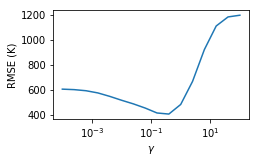

In [19]:
fig, ax = plt.subplots()

ax.semilogx(cv_model.cv_results_['param_model__gamma'], np.sqrt(-1 * cv_model.cv_results_['mean_test_score']))

ax.set_ylabel('RMSE (K)')
ax.set_xlabel('$\\gamma$')

fig.set_size_inches(3.5, 2)

In [20]:
model = cv_model.best_estimator_

In [21]:
print('Best RMSE: {:.2f} K'.format(np.sqrt(-1 * cv_model.best_score_)))

Best RMSE: 404.61 K


Now do $\alpha$

In [22]:
cv_model=GridSearchCV(model, {'model__alpha': np.logspace(-4,0,16)},
                     scoring='neg_mean_squared_error', cv=cv).fit(X, data['melting_temp'])

In [23]:
cv_model.best_params_

{'model__alpha': 0.046415888336127774}

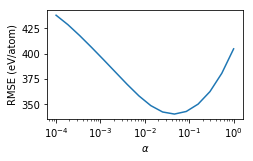

In [24]:
fig, ax = plt.subplots()

ax.semilogx(cv_model.cv_results_['param_model__alpha'], np.sqrt(-1 * cv_model.cv_results_['mean_test_score']))

ax.set_ylabel('RMSE (eV/atom)')
ax.set_xlabel('$\\alpha$')

fig.set_size_inches(3.5, 2)

In [25]:
model = cv_model.best_estimator_

In [26]:
print('Best RMSE: {:.2f} K'.format(np.sqrt(-1 * cv_model.best_score_)))

Best RMSE: 340.54 K


Note that the best parameter is in the center of the chart for both $\gamma$ and $\alpha$. This means we guessed appropriate ranges for both parameters.

Now optimize both concurrently

In [27]:
best_gamma = model.steps[-1][1].gamma
best_alpha = model.steps[-1][1].alpha

In [28]:
%%time
cv_model = GridSearchCV(model, {
    'model__gamma': np.logspace(np.log10(best_gamma)-2, np.log10(best_gamma)+2, 25),
    'model__alpha': np.logspace(np.log10(best_alpha)-2, np.log10(best_alpha)+2, 25),
}, scoring='neg_mean_squared_error', cv=cv).fit(X, data['melting_temp'])

CPU times: user 2h 1min 18s, sys: 6min 38s, total: 2h 7min 57s
Wall time: 12min 52s


In [29]:
print('Best RMSE: {:.2f} K'.format(np.sqrt(-1 * cv_model.best_score_)))

Best RMSE: 326.45 K


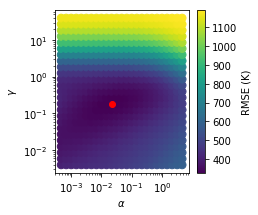

In [30]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

cb_data = ax.scatter(cv_model.cv_results_['param_model__alpha'], cv_model.cv_results_['param_model__gamma'],
                     c=np.sqrt(-1 * cv_model.cv_results_['mean_test_score']), s=60)

ax.scatter(cv_model.best_params_['model__alpha'], cv_model.best_params_['model__gamma'], color='red')

fig.colorbar(cb_data, label='RMSE (K)')

ax.set_ylabel('$\\gamma$')
ax.set_xlabel('$\\alpha$')

fig.set_size_inches(3, 3)

The red point marks our best model, which is squarely within the bounds of parameters we optimized

## Make an Automated Tool for Fitting $\gamma$ and $\alpha$
Values for $\gamma$ and $\alpha$ could be very different for different featurizers. So, we cannot rely on the grid search produced for the above model to fit the hyper parameters. Rather, we propose to use gradient decent

In [31]:
%%time
def fit_params(model, cv, X, y):
    """Fit the parameters of a KRR model using gradient decent.
    
    Args:
        model (Pipeline): Model to be fit. Last step is a KernelRidge and named "model"
        cv (BaseCrossValidator): Tool used to measure CV accuracy
        X (ndarray): Input data
        y (ndarray): Output data
    Return:
        - (Pipeline) Tuned model
        - (float) Optimized RMSE
    """
    
    # Make the scoring function
    def score(x):
        model.set_params(model__gamma=np.exp(x[0]), 
                         model__alpha=np.exp(x[1]))
        return np.sqrt(-1 * cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
    
    # Use alpha and gamma of 1 as a starting point
    x0 = [0, 0]
    
    # Run the optimization
    res = minimize(score, x0, method='Nelder-Mead', options={'disp': False})
    
    # Set the model parameters
    rmse = score(res.x)
    
    return model, rmse
model, rmse = fit_params(model, cv, X, data['melting_temp'])
print('Optimized RMSE: {:.1f} K'.format(rmse))

Optimized RMSE: 320.8 K
CPU times: user 20min 56s, sys: 1min 9s, total: 22min 5s
Wall time: 2min 12s


Plot the parameters 

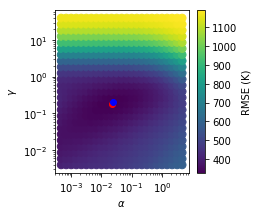

In [32]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

cb_data = ax.scatter(cv_model.cv_results_['param_model__alpha'], cv_model.cv_results_['param_model__gamma'],
                     c=np.sqrt(-1 * cv_model.cv_results_['mean_test_score']), s=60)

ax.scatter(cv_model.best_params_['model__alpha'], cv_model.best_params_['model__gamma'], color='red')
ax.scatter(model.get_params()['model__alpha'], model.get_params()['model__gamma'], color='blue')

fig.colorbar(cb_data, label='RMSE (K)')

ax.set_ylabel('$\\gamma$')
ax.set_xlabel('$\\alpha$')

fig.set_size_inches(3, 3)

The blue point is the metaparameters found by the minimization routine, which we note are very similar to the GridSearchCV result (red).

## Evaluate the models
Use 90/10 shuffle split cross-validation, as in the original paper

In [33]:
def test_model(featurizer, model=model):
    """Train a machine learning model with a certain featurizer
    
    Args:
        featurizer (BaseFeaturizer): Tool to compute features of crystal structures
        model (Pipeline): Pipeline with last step a KernelRidge named "model"
    Returns:
        (float) average RMSE
        (float) error in measurement
    """
    
    # Compute features
    X = featurizer.featurize_many(data['structure'].tolist(), pbar=False)
    y = data['melting_temp']
    
    # Fit the hyperparameters on the whole dataset
    fit_params(model, cv, X, y)
    
    # Run the cross-validation test
    mses = cross_val_score(model, X, data['melting_temp'], 
                           cv=ShuffleSplit(test_size=0.1, n_splits=200, random_state=10),
                           scoring='neg_mean_squared_error')
    rmses = np.sqrt(-1 * mses)
    return rmses.mean(), stats.sem(rmses)
test_model(models['featurizer'][3])

(309.1309082145619, 4.894823882871389)

Run all of the tests

In [34]:
models = models.assign(**dict(zip(['rmse', 'rmse_err'],
                                  zip(*[test_model(x) for x in models['featurizer']]))))

Display the results. We want to recreate Table V from the paper.

In [35]:
models['BOP'] = models['features'].apply(lambda x: 'BondOrientationalParameter' in x)

In [36]:
models['GRDF'] = models['features'].apply(lambda x: 'GeneralizedRadialDistributionFunction' in x)

In [37]:
models['STD'] = models['featurizer'].apply(lambda x: 'std_dev' in x.stats)

In [38]:
models.sort_values(['STD', 'covariance', 'BOP', 'GRDF'], inplace=True)

In [39]:
models['seko_rmse'] = [278, 302, 264, 293, 273, 277, 238, 278, 236, 301, 286, 307]

In [40]:
models[['STD', 'GRDF', 'BOP', 'covariance', 'stats', 'rmse', 'rmse_err', 'seko_rmse']]

,STD,GRDF,BOP,covariance,stats,rmse,rmse_err,seko_rmse
0,False,False,False,False,"(mean,)",252.119300,4.177777,278
3,False,True,False,False,"(mean,)",309.130908,4.894824,302
6,False,False,True,False,"(mean,)",269.585122,4.811314,264
9,False,True,True,False,"(mean,)",308.464639,4.854660,293
2,True,False,False,False,"(mean, std_dev)",242.591291,3.520922,273
5,True,True,False,False,"(mean, std_dev)",283.399491,4.903443,277
8,True,False,True,False,"(mean, std_dev)",254.964272,3.656172,238
11,True,True,True,False,"(mean, std_dev)",281.761222,4.084424,278
1,True,False,False,True,"(mean, std_dev)",232.349966,2.926844,236
4,True,True,False,True,"(mean, std_dev)",307.261182,4.537505,301


Plot our results vs Seko's 

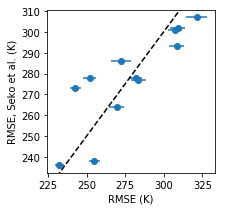

In [41]:
fig, ax = plt.subplots()

ax.errorbar(models['rmse'], models['seko_rmse'], fmt='o', xerr=models['rmse_err'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('RMSE (K)')
ax.set_ylabel('RMSE, Seko et al. (K)')

fig.set_size_inches(3, 3)

*Finding*: If our results perfectly agreed with Seko's, all the blue dots would be on the black dashed line. The points, generally, are close to the this line. So, we conclude our models are a good representation of the Seko results.

Find the best models

In [42]:
models['seko_rank'] = stats.rankdata(models['seko_rmse'])

In [43]:
models['rank'] = stats.rankdata(models['rmse'])

In [44]:
models.sort_values('rmse', ascending=True).head(4)

,covariance,featurizer,stats,features,n_features,rmse,rmse_err,BOP,GRDF,STD,seko_rmse,seko_rank,rank
1,True,"SiteStatsFingerprint(covariance=True, max_oxi=...","(mean, std_dev)",[SiteElementalProperty],275,232.349966,2.926844,False,False,True,236,1.0,1.0
2,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean, std_dev)",[SiteElementalProperty],44,242.591291,3.520922,False,False,True,273,4.0,2.0
0,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean,)",[SiteElementalProperty],22,252.119300,4.177777,False,False,False,278,6.5,3.0
8,False,"SiteStatsFingerprint(covariance=False, max_oxi...","(mean, std_dev)","[SiteElementalProperty, BondOrientationalParam...",84,254.964272,3.656172,True,False,True,238,2.0,4.0


*Finding*: Our best model agrees with that of Seko, though we do disagree for the second-best model. We do at least capture the correct order between the 3 "structure invariant" models

Save the data for later use

In [45]:
models.to_pickle('models.pkl')